In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc,rcParams
import matplotlib.font_manager as mfm
import matplotlib.patches as patches
import scipy as sp
import seaborn as sns
import nglview as nv
import MDAnalysis as mda
from MDAnalysis import Universe, Merge, transformations
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

In [2]:
plt.style.use('seaborn-white')
sns.set(style="white", context="paper") #, palette="tab10")
sns.color_palette("Set1", n_colors=8, desat=.5)
rc('font', weight='bold')
sns.set_style("ticks", {"xtick.major.size": 10, "ytick.major.size": 12})

In [3]:
wd=os. getcwd() 
resFolder = wd+"/uam/"
pdbFolder = wd+"/pdb/"
pdbCGfolder = wd+"/pdbCG/"
npFolder  = wd+"/np/"
pngFolder  = wd+"/png/"

In [4]:
pdbIn=pdbFolder+"3v03.pdb"
npIn=npFolder+"Ag100_r-26.35_zp-0.031_pristine.np"
#npIn = npFolder+"Ag111-26.35_PEG-19.9_zp-0.031.np"
uamIn=resFolder+"3v03_26_0.uam"

In [5]:
protein=pdbIn.rsplit('/')[-1].rsplit(".")[0]
basename=npIn.rsplit('/')[-1].strip(".np")
#nanopart=(basename.rsplit('_', 3)[0]).rsplit('_', 3)[0]

#core=re.sub('[^a-zA-Z]+', '', nanopart)
#radii=float(((basename.rsplit('_', 6)[1]).rsplit('_', 1)[0]).rsplit('-', 1)[1])
#zeta=float(((basename.rsplit('_', 6)[2]).rsplit('_', 1)[0]).rsplit('-', 1)[1])


def readNPFile(npIn, coreDefault="Ag", radiusDefault = 26.35,  unitScale=1.0):
    NPcoordList = []
    NPresNameArray = []
    NPRad = []
    NPBeadTypes = []
    PlotNPBeads = []
    npFile = open(npIn, "r")
    i=1
    foundCoreRadius = -1
    foundCoreMaterial = coreDefault
    beadReps = []
    for line in npFile:
        if line[0]=="#":
            continue
        #print(line)
        lineTerms = line.strip().split(",")
        legacyFile = False
        if len(lineTerms) > 8:
            legacyFile = True
        if legacyFile == True:
            #print(line)
            #print(lineTerms)
            npX, npY, npZ, npR, zeta, _, _, _, ss, _, _, _ = lineTerms
            npR = float(npR)
            #print("hamaker file: ", ss)
            solid=(((str(ss)).rsplit( "/" )[-1]).rsplit( "." ))[0]
            NPresNameArray.append([solid+str(int(npR*10)), solid, int(i)])
            NPcoordList.append([float(round(float(npX),3)*unitScale), float(round(float(npY),3)*unitScale), float(round(float(npZ),3)*unitScale)])
            NPRad.append([int(i), solid, float(npR)])
            if(npR > foundCoreRadius):
                foundCoreRadius = npR
                foundCoreMaterial = solid
            beadRep = solid+":"+str(npR)
            if beadRep not in beadReps:
                beadReps.append(beadRep)
                NPBeadTypes.append([float(npR), solid])
            PlotNPBeads.append(  [float(round(float(npX),3)*unitScale), float(round(float(npY),3)*unitScale), float(round(float(npZ),3)*unitScale) , solid , float(npR) ]   )
            i+=1
        else:
            if lineTerms[0]=="TYPE":
                npR = lineTerms[1]
                ss = lineTerms[6]
                #print(ss)
                solid=(((str(ss)).rsplit( "/" )[-1]).rsplit( "." ))[0]
                NPBeadTypes.append( [ float(npR), solid])
                #print(NPBeadTypes)
                beadRep = solid+":"+str(npR)
                if beadRep not in beadReps:
                    beadReps.append(beadRep) 
            elif lineTerms[0]=="BEAD":
                beadType = int( lineTerms[1])
                try:
                    beadParams = NPBeadTypes[beadType]
                except:
                    beadParams = [5,"err"]
                    print("Bead type not found")
                #print(line)
                solid = beadParams[1]
                npR = beadParams[0]
                npX = float(lineTerms[2])
                npY = float(lineTerms[3])
                npZ = float(lineTerms[4])                
                NPresNameArray.append([solid+str(int(npR*10)), solid, int(i)])
                NPcoordList.append([float(round(npX,3)*unitScale), float(round(npY,3)*unitScale), float(round(npZ,3)*unitScale)])
                NPRad.append([int(i), solid, float(npR)])
                if(npR > foundCoreRadius):
                    foundCoreRadius = npR
                    foundCoreMaterial = solid
                i+=1
                PlotNPBeads.append(  [float(round(float(npX),3)*unitScale), float(round(float(npY),3)*unitScale), float(round(float(npZ),3)*unitScale) , solid , float(npR) ]   )
    npFile.close()
    if len(NPcoordList) == 0:
        print("No NP found in file, adding the default")
        NPcoordList.append( [0.0,0.0,0.0])
        NPresNameArray.append([coreDefault+str(radiusDefault),coreDefault, 1])
        NPRad.append([1,coreDefault, radiusDefault])
        foundCoreMaterial = coreDefault
        foundCoreRadius = radiusDefault
    return NPcoordList, NPresNameArray, NPRad, foundCoreMaterial, foundCoreRadius, NPBeadTypes, PlotNPBeads
'''       
rawNP         = np.genfromtxt(npIn,  delimiter=',' , skip_header=1, dtype=None)
NPcoordList=[]
NPresNameArray=[]
NPRad=[]
npInnerRadius = -1
if rawNP.size > 1:
    i=1
    for line in rawNP:
        npX, npY, npZ, npR, _, _, _, _, ss, _, _, _ = line
        solid=(((str(ss)).rsplit( "/" )[2]).rsplit( "." ))[0]
        NPresNameArray.append([solid, solid, int(i)])
        NPcoordList.append([float(round(npX,3)*10), float(round(npY,3)*10), float(round(npZ,3)*10)])
        NPRad.append([int(i), solid, float(npR)])
        npInnerRadius = max(npR,npInnerRadius)
        i=i+1
if rawNP.size ==1:
    NPcoordList.append([0.0, 0.0, 0.0])
    NPresNameArray.append([core,core, 1])
    NPRad.append([1,core, radii])
'''    
NPcoordList, NPresNameArray, NPRad ,core,radii, NPBeadTypes, PlotNPBeads= readNPFile(npIn, "Default", 10, unitScale=10.0)
    
NPcoord=np.array(NPcoordList)
NPres=np.array(NPresNameArray)
NPRs=np.array(NPRad)
#print(NPcoord)
#print(NPRad)
#print(radii)
print(NPBeadTypes)
#print(PlotNPBeads)
print(NPres)

[[26.35, 'Ag']]
[['Ag263' 'Ag' '1']]


# Read in UAM, plot heatmap and find min conformation

Text(0, 0.5, '$\\theta$°')

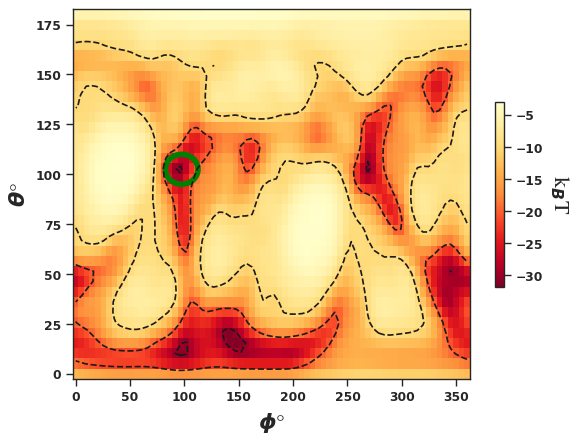

In [6]:
rawData         = np.genfromtxt(uamIn)
phiData         = rawData[:,0]
thetaData       = rawData[:,1]
energy          = rawData[:,2]
sdData          = rawData[:,3]
ssdData         = rawData[:,4]
sinTheta        = np.sin(thetaData * np.pi / 180.0)
boltzmanAverage = np.sum(energy * sinTheta * np.exp(-1.0 *  energy)) / np.sum(sinTheta * np.exp(-1.0 * energy))
simpleAverage   = np.mean(sinTheta * energy)
index           = np.argmin(energy)
delta           = phiData[1] - phiData[0]
rows            = int(180. / delta)
cols            = int(360. / delta)
image           = np.zeros((rows, cols))

#Select first lowest conformation
conf_id = 0
conf_phi = phiData[index]
conf_theta = thetaData[index]
conf_ssd = ssdData[index]
conf_ene = energy[index]

#print(conf_phi,conf_theta)

#for phi, theta , energy , sd ,ssd, mfpt ,energy_kj, prot_surf_com_dist in rawData:
for line in rawData:
    phi = line[0]
    theta = line[1]
    energy = line[2]
    row             = int(theta / delta)
    col             = int(phi / delta)
    image[row][col] = energy

lon = np.linspace(0, 360, cols)
lat = np.linspace(0, 180, rows)
Lon, Lat = np.meshgrid(lon,lat)
image = sp.ndimage.filters.gaussian_filter(image, sigma = [1.0, 1.0], mode = ['constant', 'wrap'])

# Plot the data
font_path = "/usr/share/fonts/truetype/freefont/FreeSerif.ttf"
fontsize  = 16
clabelpad = 20

font      = mfm.FontProperties(fname = font_path, size = fontsize)
xlabel    = r"$\phi$" + u"\u00B0"
ylabel    = r"$\theta$" + u"\u00B0"
clabel    = r"k${_B}$T";

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(Lon, Lat, image, cmap = plt.cm.YlOrRd_r)  #plt.cm.binary_r )
plt.contour(Lon, Lat, image, 2, colors='k')
#plt.scatter(conf_phi+2.5, conf_theta+2.5 ,marker="X",color="#0000ff",s=120)
circleWidth = 15
ax.add_patch(  patches.Ellipse((conf_phi+2.5, conf_theta+2.5), circleWidth*2,circleWidth, color='green', fill=False, lw=4) )
cb = fig.colorbar(im, ax = ax, shrink = 0.5)
cb.set_label(clabel, rotation = 270, labelpad = clabelpad, fontproperties = font)
ax.set_xlabel(xlabel, fontproperties = font)
ax.set_ylabel(ylabel, fontproperties = font)


In [7]:
res_png = 900
figname_map_png=pngFolder+protein+"_"+basename +  "_heatmap.png"
figname_map_png
fig.savefig(figname_map_png, format='png', dpi=res_png,  transparent=True)

# Read in PDB for protein and transform accordinly to orientation data

In [9]:
'''

#  translation to origin

print(u_prot.atoms.positions[0])
#translate_to_origin = transformations.center_in_box(u_prot.atoms,center='mass', point=[0.0,0.0,0.0])


# UA rotation

rawCoords = u_prot.atoms.positions

rawCoords[:,0] = rawCoords[:,0] - np.sum(rawCoords[:,0])/len(rawCoords[:,0])
rawCoords[:,1] = rawCoords[:,1] - np.sum(rawCoords[:,1])/len(rawCoords[:,0])
rawCoords[:,2] = rawCoords[:,2] - np.sum(rawCoords[:,2])/len(rawCoords[:,0])

print(rawCoords[0])



#rotate

print(minPhi,minTheta)
rotCoords =  rotatePDB(rawCoords ,rot_phi, rot_theta)
print(rotCoords[0])

rotCoords[:,2] = rotCoords[:,2] - np.amin(rotCoords[:,2]) + (radii + conf_ssd + 0.5)*10
print(rotCoords[0])
u_prot.atoms.positions=rotCoords
print(u_prot.atoms.positions[0])
print( np.mean( rotCoords[:,0]))
print( np.mean( rotCoords[:,1]))
print( np.mean( rotCoords[:,2]))
print( np.amin( rotCoords[:,2]))
#
#pHalf=(u_prot.atoms.center_of_mass()[2]-u_prot.atoms.positions.T[2].min())*0.1 # in nm

#npR+ssd in z dir in A plus an extra offset of 0.5 nm to account for the typical bead radius
#translate_by_ssd = transformations.center_in_box(u_prot.atoms,center='mass', point=[0.0,0.0,(pHalf+radii+conf_ssd+0.5)*10])
'''
#  Ian's code for rotation
def rotatePDB(coords,phi,theta):
    rxx = np.cos(theta)*np.cos(phi)
    rxy = -1 * np.cos(theta)*np.sin(phi)
    rxz = np.sin(theta)
    ryx = np.sin(phi)
    ryy = np.cos(phi)
    ryz = 0
    rzx = -1*np.sin(theta)*np.cos(phi)
    rzy = np.sin(theta)*np.sin(phi)
    rzz = np.cos(theta)
    finalCoords = np.zeros_like(coords)
    
    finalCoords[:,0] = coords[:,0] * rxx + coords[:,1] * rxy + coords[:,2]*rxz 
    finalCoords[:,1] = coords[:,0] * ryx + coords[:,1] * ryy + coords[:,2]*ryz 
    finalCoords[:,2] = coords[:,0] * rzx + coords[:,1] * rzy + coords[:,2]*rzz 
    return finalCoords

def tUACOM():
    def wrapped(ts):
        ts.positions += np.array(  [ -np.mean(ts.positions[:,0]) ,- np.mean(ts.positions[:,1]), -np.mean(ts.positions[:,2])  ]  )
        return ts
    return wrapped
        
def tUARotate(phi,theta):
    def wrapped(ts):
        ts.positions = rotatePDB(ts.positions,phi,theta)
        return ts
    return wrapped

def tUAZShift(dz):
    def wrapped(ts):
        ts.positions += np.array( [0.0,0.0,dz - np.amin(ts.positions[:,2])])
        return ts
    return wrapped


minTheta = conf_theta  + 2.5
minPhi = conf_phi + 2.5
rot_phi   = -1.0 * minPhi  * (np.pi / 180.0)
rot_theta = (180.0 - minTheta) * (np.pi / 180.0)

u_prot = Universe(pdbIn)
translateToCOM = tUACOM()
applyRotation = tUARotate( rot_phi, rot_theta)
translateToSurface = tUAZShift( 10*(radii+conf_ssd+0.5) )

u_prot.trajectory.add_transformations(*[translateToCOM,applyRotation,translateToSurface])

In [10]:
viewProt=nv.show_mdanalysis(u_prot)
viewProt._remote_call('setSize', target='Widget', args=['600px','600px'])
viewProt.add_representation(repr_type='cartoon', selection='protein', color='residueindex')
viewProt

NGLWidget()

# Combine with NP coordinate

In [11]:

hamakerToElementDataFile = open("NPbeadtypedefinitions.csv","r")
elemDic ={}
typeDic = {}
beadDicRGB = {}
beadDicHex = {}
materialPropertiesDict ={}

def rgbToHex(rgb):
    return int(  "0x"+('{:02X}' * 3).format(int(round(rgb[0]*255)), int(round(rgb[1]*255)), int(round(rgb[2]*255))),16)

#expected format: Hamaker file, short element-like symbol, type, R (0-1), G (0-1), B(0-1)
for line in  hamakerToElementDataFile:
    if line[0] == "#":
        continue
    lineTerms = line.strip().split(",")
    
    elemDic[lineTerms[0]] = lineTerms[1]
    typeDic[lineTerms[0]] = lineTerms[2]
    rc =  np.clip ( float(lineTerms[3]),0,1)
    gc = np.clip( float(lineTerms[4]),0,1)
    bc = np.clip( float(lineTerms[5]),0,1)
    beadDicRGB[lineTerms[0]] = [ rc,gc,bc ]
    beadDicHex[lineTerms[0]] = rgbToHex( [ rc,gc,bc ])
    materialPropertiesDict[ lineTerms[0] ] = [ lineTerms[1], lineTerms[2] , [rc,gc,bc] , rgbToHex([rc,gc,bc])]
    

    

In [12]:
nameLst=[]
resLst=[]
typeLst=[]
elemLst=[]
coorArr=[]
for i, line in enumerate(NPres):
    npHamakerType = line[1]
    if npHamakerType not in typeDic:
        print("Warning: ", line[1], " not a known type of NP. Using auto-generated colours and label, please update NPbeadtypedefinitions.csv") 
        typeName = npHamakerType
        typeDic[typeName] = (typeName+"XXX")[:3]
        elemDic[typeName] = (typeName+"XXX")[:2]
        beadDicRGB[typeName] = [   1.0, 0, 1.0]
        beadDicHex = rgbToHex( [1.0,0,1.0])
    typeLst.append(typeDic[npHamakerType])
    elemLst.append(elemDic[npHamakerType])
    nameLst.append(line[0] )
    resLst.append(npHamakerType)
    coorArr.append(NPcoord[i])
    
#print(nameLst)
#print(typeLst)
n_residues = len(NPres)
n_atoms = len(NPres)
resindices = np.repeat(range(n_residues), 1)
assert len(resindices) == n_atoms
segindices = [0] * n_residues
u_nano = mda.Universe.empty(n_atoms,
                         n_residues=n_residues,
                         atom_resindex=resindices,
                         residue_segindex=segindices,
                         trajectory=True)
u_nano.add_TopologyAttr('name', nameLst)
u_nano.add_TopologyAttr('type', typeLst)
u_nano.add_TopologyAttr('elements', elemLst)
u_nano.add_TopologyAttr('resname', resLst)
u_nano.add_TopologyAttr('resid', list(range(1, n_residues+1)))
u_nano.add_TopologyAttr('segid', ["NP"])
u_nano.atoms.positions = coorArr

pdb_combo=pdbCGfolder+core+"_"+str(protein)+'_CG.pdb'
combo = Merge(u_prot.atoms, u_nano.atoms)
combo.atoms.write(pdb_combo)

# Visualize NP-protein complex

In [13]:
#generate dummy spheres for testing
thetaRange = np.linspace( 0, np.pi, 3)
phiRange = np.linspace(0, 2*np.pi,5)
dummyBeadCenters = []
for theta in thetaRange:
    for phi in phiRange:
        dummyBeadCenters.append( [np.cos(phi)*np.sin(theta),np.sin(phi)*np.sin(theta),np.cos(theta)] )
dummyBeads = np.array(dummyBeadCenters)
numNPBeads = len(PlotNPBeads)

view=nv.show_mdanalysis(combo)
view._remote_call('setSize', target='Widget', args=['400px','600px'])
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='protein', color='residueindex')
view.add_representation(repr_type='surface', surfaceType= 'av',  opaqueBack=False, selection='protein', opacity=0.05, color='indigo')


beadRadiusScale = 10
for beadType in NPBeadTypes:
    beadRadius = beadType[0]
    beadMaterial = beadType[1]
    equivName = beadMaterial+str(int(beadRadius*10))
    #beadTypeIndices= np.nonzero(np.logical_and(  NPRs[:,1]==beadMaterial,  np.abs( NPRs[:,2].astype(float)   - beadRadius) < 0.05) )[0]
    beadTypeIndices = combo.select_atoms("name "+equivName ).ix
    #print(beadTypeIndices)
    if beadMaterial in materialPropertiesDict:
        beadColourHex = materialPropertiesDict[beadMaterial][3]
        beadColourRGB = materialPropertiesDict[beadMaterial][2]
    else:
        #beadColourHex = "0x000000"
        beadColourRGB = [1,0,1]
        beadColourHex = rgbToHex(beadColourRGB )
        print("Warning: No colour set for ", beadMaterial)
    if len(beadTypeIndices) < 1:
        continue
    print("Adding", len(beadTypeIndices) , "beads of radius", beadRadius, "material: ", beadMaterial, " colour:", beadColourHex)
    minBeadRadius = 10
    plotRadius = min(beadRadiusScale*minBeadRadius, beadRadiusScale*beadRadius)
    view.add_representation('spacefill',  selection=beadTypeIndices, color=beadColourHex, opacity=1.0,  radius=plotRadius, scale=1, radiusType="size")



#for bds in list(beadDicHex.keys()):
#    view.add_representation(repr_type='spacefill', selection=bds,  opacity=0.6, color=beadDicHex[bds], radius=(radii*10))
central = view.shape
#central.add_sphere([ 0.0, 0.0, 0.0 ], [1.0,0.0,0.0], radii* 1,core+"1x")

outersurfaceRadius = 0
#plot larger beads as spheres
for npBead in PlotNPBeads:
    npBeadLoc = np.array( npBead[0:3] ) *10
    npBeadRadius = float(npBead[4])*10
    if npBeadRadius < 50:
        continue
    #print("adding sphere for ", npBead)
    beadMaterial = npBead[3]
    central.add_sphere( npBeadLoc ,  beadDicRGB[beadMaterial], npBeadRadius,beadMaterial)
    outersurface = max(npBeadRadius,outersurfaceRadius)
    for dummyBead in dummyBeads:
        dbArr = np.array(dummyBead)
        #print(dbArr)
        dbLoc = (dbArr * npBeadRadius*0.8) +  npBeadLoc 
        #print("Adding dummy bead at: ", dbLoc)
        central.add_sphere(dbLoc,  beadDicRGB[beadMaterial], 1,beadMaterial)

        
#add an axis - just for debugging
addAxis = False
if addAxis == True:
    central.add_cylinder( [0,0,outersurfaceRadius+100] , [600,0,outersurfaceRadius+100 ], [1.0,0.0,0.0], 25 ) #x
    central.add_cylinder( [0,0,outersurfaceRadius+100] , [0,600,outersurfaceRadius+100 ], [0.0,1.0,0.0], 25 ) #y
    central.add_cylinder( [0,0,outersurfaceRadius+100] , [0,0,600+outersurfaceRadius+100 ], [0.0,0.0,1.0], 25) #z
        
#central.add_sphere([ 0.0, 0.0, 0.0 ], [0.0,1.0,0.0], radii* 10,core+"10x")
view.center()
view.control.spin([1,0,0], 90*np.pi/180.0)
view.control.spin([0,1,0],np.pi)
#view.control.spin([1,0,0], 90*np.pi/180.0)
#view.control.spin([0,1,0], 25*np.pi/180.0)
view

Adding 1 beads of radius 26.35 material:  Ag  colour: 14408667


NGLWidget()

In [13]:
view.parameters = dict(theme='light')
filename=core+"_"+str(protein)+'_CG.png'
view.download_image(filename=filename , factor=10, transparent=True)
filename

'Ag_3v03_CG.png'